In [1]:
import sklearn
from sklearn.datasets import load_boston, load_diabetes
import tensorflow.compat.v2 as tf
import tensorflow.keras as keras
import sys
import matplotlib.pyplot as plt
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import List, Tuple
from num2words import num2words
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import pandas as pd
sys.path.insert(0,' ../')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
from collections import defaultdict

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Load data

In [4]:


mnist = MNIST('../data')
x_train, y_train = mnist.load_training() #60,000 samples
x_test, y_test = mnist.load_testing()    #10,000 samples

In [5]:
x_train_img = [np.asarray(x_train).astype(np.float32)[i].reshape(28,28,1) for i in range(3)]


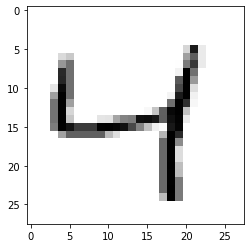

In [6]:
plt.imshow(x_train_img[2], cmap='Greys')

In [7]:
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.int32)
x_test =  np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.int32)

# Primitive functions


### Sin

Text(0.5, 1.0, 'Sin')

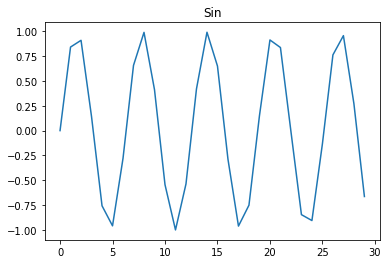

In [8]:
sin = plt.plot(np.sin(np.arange(0,30)))
plt.title('Sin')

### Cosin

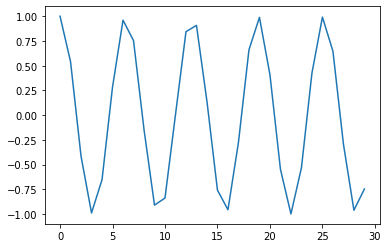

In [9]:
plt.plot(np.cos(np.arange(0,30)))

#### sqrt

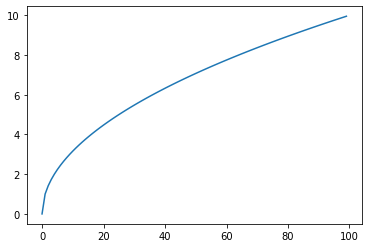

In [10]:
plt.plot(np.sqrt(np.arange(0,100)))

### log

Text(0.5, 1.0, 'log')

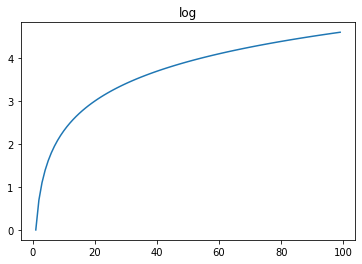

In [11]:
plt.plot(np.log(np.arange(0,100)))
plt.title('log')

- Custom primitive functions

In [71]:
class MathFunctions():
    def __init__(self,weight):
        """weight is the parameter applied to all functions"""
        self.weight = weight
        self.overflow_number = 9e3

    def mf_sum(self, input_data):
       return  self.__x_number_sum(input_data)
    
    def mf_sigmoid(self, input_data):
        output = []
        if type(input_data) == list:
            input_data = np.array(input_data)
        for i in input_data:
            try:
                sig = 1 / (1 + math.exp(-i))
            except Exception:
                sig = self.overflow_number
            output.append(sig)
        return output
    
    def mf_pos_step_function(self, input_data):
        if type(input_data) == list:
            input_data = np.array(input_data)
        copy_input_data = input_data.copy()
        second_copy_input_data = input_data.copy()
        copy_input_data[copy_input_data > 0] = 1
        copy_input_data[copy_input_data <= 0] = 0
        return copy_input_data * second_copy_input_data # only pass on positive values

    def mf_neg_step_function(self, input_data):
        if type(input_data) == list:
            input_data = np.array(input_data)
        copy_input_data = input_data.copy()
        second_copy_input_data = input_data.copy()
        copy_input_data[copy_input_data >= 0] = 0
        copy_input_data[copy_input_data < 0] = 1

        return copy_input_data * second_copy_input_data # only pass on negative values

    def mf_running_avg(self, input_data):
       return  self.__x_number_average(input_data)
    
    def mf_discrete_avg(self, input_data):

        ids = np.arange(len(input_data))//self.weight
        return np.bincount(ids,input_data)/np.bincount(ids)
    
    def mf_max_pool(self, input_data):
        new_max = []
        if type(input_data) == list:
            input_data = np.array(input_data)
            
        for i in range(0,len(input_data),self.weight):
            new_max.append(np.max(input_data[i:i+self.weight]))
        
        return new_max
    
    def mf_convolve(self, input_data):
        kernel = np.ones(self.weight)
        kernel = kernel*self.weight
        return np.convolve(input_data,kernel, 'valid')
        
        
    def mf_inverse(self, input_data):
        if type(input_data) == list:
            input_data = np.array(input_data)
        return input_data*-1
                   
    def mf_pow(self, input_data):
        return  np.power(input_data, self.weight)
    
    def mf_linear_transform(self, input_data):
        return input_data*self.weight + self.weight
    

    def __x_number_average(self, input_data):
        if type(input_data) == list:
            input_data = np.array(input_data)

        weight = self.weight
        if len(input_data) <= weight:
            return np.mean(input_data)

        len_ = len(input_data)
        new_data = []
        previous_row = 0
        for i in range(weight, len_+1):
            new_data.extend(
                [
                    np.mean(
                        input_data[previous_row: i]
                        )
                    ]
                )
            previous_row+=1
            
        return np.array(new_data)

    def __x_number_sum(self, input_data):
        if type(input_data) == list:
            input_data = np.array(input_data)

        weight = self.weight
        if len(input_data) <= weight:
            return np.sum(input_data)

        len_ = len(input_data)
        new_data = []
        previous_row = 0
        for i in range(weight, len_+1):

            new_data.extend([np.sum(input_data[previous_row: i])])
            previous_row += 1
        return np.array(new_data)

        
        

    

In [72]:
 # weight params
custom_math_functions= MathFunctions(4)

In [73]:
assert custom_math_functions.mf_running_avg([10,10,20,20,10]).all() == np.array([15,15]).all()
assert custom_math_functions.mf_sum([10,10]) == [20]
assert custom_math_functions.mf_pow([10]) == [10000]

In [74]:
TEST_NUMBERS = np.arange(-100, 100)

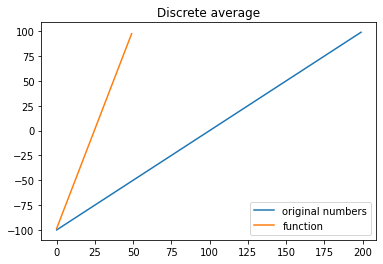

In [75]:
plt.title('Discrete average')
plt.plot(TEST_NUMBERS, label='original numbers')
plt.plot(custom_math_functions.mf_discrete_avg(TEST_NUMBERS), label='function') 
plt.legend()

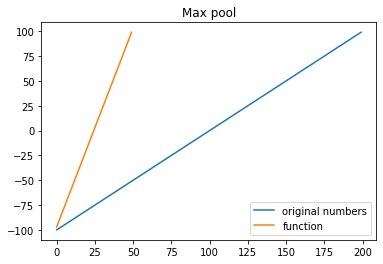

In [76]:
plt.title('Max pool')
plt.plot(TEST_NUMBERS, label='original numbers')
plt.plot(custom_math_functions.mf_max_pool(TEST_NUMBERS), label='function') 
plt.legend()

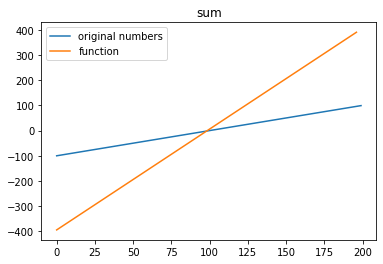

In [77]:
plt.title('sum')
plt.plot(TEST_NUMBERS, label='original numbers')
plt.plot(custom_math_functions.mf_sum(TEST_NUMBERS), label='function') 
plt.legend()

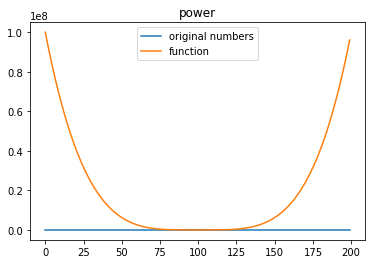

In [78]:
plt.title('power')
plt.plot(TEST_NUMBERS, label='original numbers')
plt.plot(custom_math_functions.mf_pow(TEST_NUMBERS), label='function') 
plt.legend()

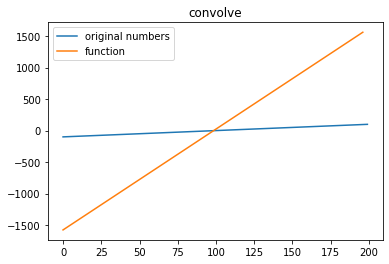

In [79]:
plt.title('convolve')
plt.plot(TEST_NUMBERS, label='original numbers')
plt.plot(custom_math_functions.mf_convolve(TEST_NUMBERS), label='function') 
plt.legend()

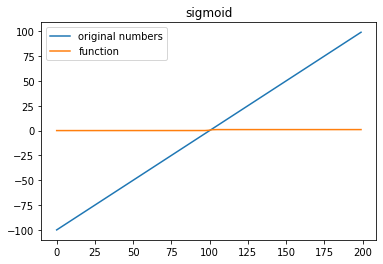

In [80]:
plt.title('sigmoid')
plt.plot(TEST_NUMBERS, label='original numbers')
plt.plot(custom_math_functions.mf_sigmoid(TEST_NUMBERS), label='function') 
plt.legend()

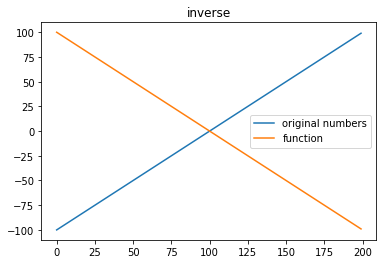

In [81]:
plt.title('inverse')
plt.plot(TEST_NUMBERS, label='original numbers')
plt.plot(custom_math_functions.mf_inverse(TEST_NUMBERS), label='function') 
plt.legend()

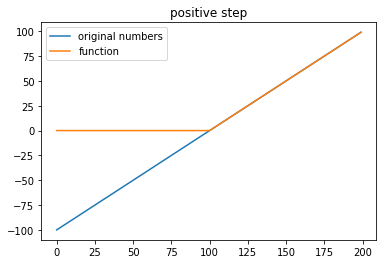

In [82]:
plt.title('positive step')
plt.plot(TEST_NUMBERS, label='original numbers')
plt.plot(custom_math_functions.mf_pos_step_function(TEST_NUMBERS), label='function') 
plt.legend()

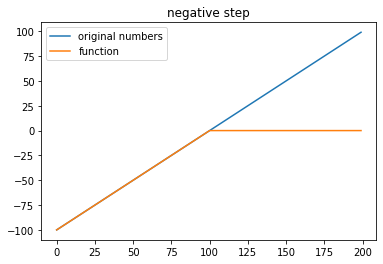

In [83]:
plt.title('negative step')
plt.plot(TEST_NUMBERS, label='original numbers')
plt.plot(custom_math_functions.mf_neg_step_function(TEST_NUMBERS), label='function') 
plt.legend()

# Define a non NN model

In [84]:
class RandomModelArchitecture():
    
    def __init__(self, n_pixel_to_process, primitive_functions, math_function_class):
        self.math_function_class = math_function_class
        self.primitive_functions = primitive_functions
        self.n_pixel_to_process = n_pixel_to_process
        self.overflow_number = 9e3
        
    def set_rmse(self, rmse):
        self.rmse = rmse
        
    def set_loss(self,loss):
        self.loss = loss

        
    def get_random_architecture(self, input_image):
        """
        Return a list of strings corresponds to a model architecture for the given 
        """
        model_architecture = []
        while len(input_image) !=0:

            #pick the number to apply
            function_n = np.random.randint(len(self.primitive_functions))
            math_function_str = self.primitive_functions[function_n]
            if 'mf' in math_function_str:
                function_module = getattr(self.math_function_class, math_function_str)
            else:
                function_module = getattr(numpy, math_function_str)
            # Transform the image with the corresponding primitive function choosen
            input_image = function_module(input_image)

            model_architecture.append(math_function_str)
            # housekeeping in case our primitive functions go wonky
            input_image = np.nan_to_num(input_image)
            try:
                input_image[input_image == -np.inf] = 0
            except Exception as e:
                print(e)
                print(input_image)
            if  type(input_image) == numpy.float64 or type(input_image) == numpy.float32:
                break
            elif len(input_image) <= self.n_pixel_to_process: #Largest consolidation function
                break
        self.model_architecture = model_architecture


    def get_prediction_from_architecture(self, input_image):
        
        n_functions = len(self.model_architecture)
        for idx, math_function_str in enumerate(self.model_architecture):

            if  n_functions == idx+1: #Largest consolidation function

                # For now, just take the  mean of the last elements
                final_prediction = np.mean(input_image) 

                if np.isinf(final_prediction):
                    final_prediction = self.overflow_number
                elif final_prediction == np.nan:
                    final_prediction = self.overflow_number
                return final_prediction

            if 'mf' in math_function_str:
                function_module = getattr(self.math_function_class, math_function_str)
            else:
                function_module = getattr(numpy, math_function_str)

            # Transform the image with the corresponding primitive function choosen
            input_image = function_module(input_image)
            # housekeeping in case our primitive functions go wonky
            input_image = np.nan_to_num(input_image, self.overflow_number)
            input_image[input_image == -np.inf] = self.overflow_number

    def agument_existing_architecture_list(self, input_image, augment_percent=0.80):
        """,
        For our genetic algorithm, given a list of architectures, keep the first half and randomly generate the second half
        """
        n_functions_in_architecture = len(self.model_architecture)


        if type(self.model_architecture) == list:
            self.model_architecture = np.array(self.model_architecture)
            
        n_functions_to_keep = int(augment_percent*n_functions_in_architecture)
        new_architecture_list = list(self.model_architecture[:n_functions_to_keep])

        for math_function_str in new_architecture_list:
            if 'mf' in math_function_str:
                function_module = getattr(self.math_function_class, math_function_str)
            else:
                function_module = getattr(numpy, math_function_str)

            # Transform the image with the corresponding primitive function choosen
            input_image = function_module(input_image)
            # housekeeping in case our primitive functions go wonky
            input_image = np.nan_to_num(input_image , self.overflow_number)
            input_image[input_image == -np.inf] = self.overflow_number

        # Now, randomly generate the second half of the arhictecture
        while len(input_image) !=0:

            #pick the number to apply
            function_n = np.random.randint(len(self.primitive_functions))
            math_function_str = self.primitive_functions[function_n]
            if 'mf' in math_function_str:
                function_module = getattr(self.math_function_class, math_function_str)
            else:
                function_module = getattr(numpy, math_function_str)
            # Transform the image with the corresponding primitive function choosen
            input_image = function_module(input_image)

            new_architecture_list.append(math_function_str)
            # housekeeping in case our primitive functions go wonky
            input_image = np.nan_to_num(input_image, self.overflow_number)
            try:
                input_image[input_image == -np.inf] = self.overflow_number
            except Exception as e:
                print(e)
                print(input_image)
                
            if  type(input_image) == numpy.float64 or type(input_image) == numpy.float32:
                break
            elif len(input_image) <= self.n_pixel_to_process: #Largest consolidation function
                break
        self.model_architecture = np.array(new_architecture_list)

    
    

In [85]:
class BestRMAClass(RandomModelArchitecture):
    pass

In [86]:
def generate_new_architectures(x_train,y_train, best_models_this_gen, NUM_ARCHITECTURES,
                               PRIMITIVE_FUNCTIONS_LIST, NUM_IMAGES_PER_ARCHITECTURE, math_functions = MathFunctions):
    # shuffle x and y 
    shuffler = np.random.permutation(len(x_train))
    # don't shuffle
    xtrain_shuffled = x_train #[shuffler]
    ytrain_shuffled = y_train #[shuffler]
    

        

    INCORRECT_LOSS = 9e4 # wrong class loss
    UPPER_BOUND_N_PIXELS_PROCESS = 10
    INF_WEIGHT_PENALITY = 9e3
    
    gen_constant_loss = []
    gen_var = []
    gen_models = []
    gen_loss = []
    gen_n_random_models = 0
    for arch_idx in tqdm(range(NUM_ARCHITECTURES)):
        if len(best_models_this_gen) > 0:
            n_best_architectures = len(best_models_this_gen)
        else:
            n_best_architectures = 0

        # new image
        all_predictions=[]
        all_y_labels=[]

        # gen -, all random, or random until we meet the total number of architectures we want
        if (gen == 0) or (arch_idx  >= n_best_architectures):

            RANDOM_WEIGHT = np.random.randint(2,UPPER_BOUND_N_PIXELS_PROCESS)
            custom_math_functions = math_functions(RANDOM_WEIGHT)
            rma = RandomModelArchitecture(RANDOM_WEIGHT, PRIMITIVE_FUNCTIONS_LIST, custom_math_functions)
            rma.get_random_architecture(SAMPLE_IMAGE)
            gen_n_random_models+=1
        else: # previous architectures we've updated
            rma = best_models_this_gen[arch_idx]
            
        gen_models.append(rma)

        for img_idx, img in enumerate(xtrain_shuffled[0:NUM_IMAGES_PER_ARCHITECTURE,...]):
            y_true = ytrain_shuffled[img_idx]
            all_y_labels.append(y_true)

            prediction = rma.get_prediction_from_architecture(img.copy())
            if np.isnan(prediction) or prediction == np.inf:
                prediction = INF_WEIGHT_PENALITY
            all_predictions.append(int(prediction))

        if type(all_y_labels) == list:
            all_y_labels = np.array(all_y_labels)
        if type(all_predictions) == list:
            all_predictions = np.array(all_predictions)
    
        model_constant_loss = np.sum(all_y_labels != all_predictions) * INCORRECT_LOSS
        model_rmse = np.sqrt(mean_squared_error(all_y_labels, all_predictions))
        if model_rmse == np.inf or np.isnan(model_rmse):
            model_rmse = INF_WEIGHT_PENALITY
        if model_constant_loss == np.inf or np.isnan(model_constant_loss):
            model_constant_loss = INF_WEIGHT_PENALITY
        gen_constant_loss.append(model_constant_loss)
        rma.set_rmse(model_rmse)
        # penalize models that predict the same thing
        model_pred_var = np.var(all_predictions)
        if model_pred_var == 0:
            model_pred_var = ZERO_VAR_PENALTY
        else:
            model_pred_var = (1 / model_pred_var) * ZERO_VAR_PENALTY

        gen_var.append(model_pred_var)
        total_loss = model_pred_var + model_rmse + model_constant_loss
        
        if total_loss == np.inf:
            total_loss = INF_WEIGHT_PENALITY
        gen_loss.append(total_loss)
        rma.set_loss(total_loss)
    print(f" Generated {gen_n_random_models} random models this generation")
        
    return     gen_constant_loss , gen_var, gen_models, best_models_this_gen, gen_loss

### Training

In [28]:
300//1.5

200.0

In [87]:
PRIMITIVE_FUNCTIONS_LIST = [ 'log', 'mf_pow', 'cos', 'sin', 'tan', 'abs', 'mf_sum', 'mf_convolve', 'mf_running_avg', 'mf_pos_step_function',
                            'mf_neg_step_function', 'mf_linear_transform', 'mf_inverse', 'mf_discrete_avg', 'mf_max_pool', 'mf_sigmoid']

FINAL_MODEL_CLASSES = []  # RMA classes
FIRST_GEN_CLASSES = []
AVG_RMSE_PER_GENERATION = []
FINAL_GENERATION_RMSE = []
FINAL_GENERATION_LOSS = []
BEST_CLASS_ACROSS_GEN = []
ALL_TOP_HALF_LOSS = []
ALL_AVG_LOSS = []
ALL_TOP_CLASS_LOSS = []
BEST_RMA_CLASS = None
CURRENT_BEST_LOSS = 9e100
SAMPLE_IMAGE = x_train[0,...].copy()
best_architectures = None
best_models_this_gen = []
ZERO_VAR_PENALTY=2e5
n_generations_waited=0




## These are the main parameters to adjust
NUM_IMAGES_PER_ARCHITECTURE = 50 # how many images each model sees to calculate loss
NUM_ARCHITECTURES = 50 # num per generation
N_GENERATIONS = 300 # how many genreations
PATIENCE = N_GENERATIONS//1.5 ## generations to wait
PERCENT_BEST_ARCHITECTURE_TO_KEEP_NEXT_GEN=0.30 # this should be inverse ADDITIONAL_BEST_ARCHITECTURE_PCT, what percent of the  best architecture to change gen / gen
ADDITIONAL_BEST_ARCHITECTURE_PCT = 0.30 #For the model with the lowest loss, what percent of models should start from this best model
BEST_LOSS_THRESHOLD = int(NUM_IMAGES_PER_ARCHITECTURE//2)

## generate balanced y_train / x_train
balanced_y_train = []
balanced_x_train = []
N_IMAGES_BALANCED = int(1/10 * NUM_IMAGES_PER_ARCHITECTURE)
n_images_per_class = defaultdict(int)
total_n_images = 0
counter = 0

while total_n_images <= NUM_IMAGES_PER_ARCHITECTURE:
    current_y = y_train[counter]
    current_x = x_train[counter]
    
    if n_images_per_class[current_y] > N_IMAGES_BALANCED:
        pass
    else:
        balanced_y_train.append(current_y)
        balanced_x_train.append(current_x)
        n_images_per_class[current_y] += 1
        total_n_images += 1
    counter += 1
balanced_y_train = np.array(balanced_y_train) 
balanced_x_train = np.array(balanced_x_train)
    


#### TRAINING CODE
start_time = time.time()
for gen in range(N_GENERATIONS):
    if gen%10==0:
        print("-----------------")
        print(f"Generation {gen+1} out of {N_GENERATIONS}")
        print("-----------------")
        # New architectures
        print(f" The number of models that are below our loss threshold of {BEST_LOSS_THRESHOLD}, or from our previous gen, of the top half are {len(best_models_this_gen)} \
              out of a total of {NUM_ARCHITECTURES} architectures")
    
    
    gen_rmse , gen_var, gen_models, best_models_this_gen, gen_loss = generate_new_architectures(balanced_x_train,balanced_y_train,
                                                                                                best_models_this_gen,
                                                                                                NUM_ARCHITECTURES,  
                                                                                                PRIMITIVE_FUNCTIONS_LIST, 
                                                                                                NUM_IMAGES_PER_ARCHITECTURE)
    if type(gen_rmse) == list:
        gen_rmse = np.array(gen_rmse)
    gen_rmse[gen_rmse == np.inf] = 999999
    FINAL_GENERATION_RMSE.append(gen_rmse)
    FINAL_MODEL_CLASSES.append(gen_models)
    if gen== 0:
        FIRST_GEN_CLASSES.extend(gen_models)
    FINAL_GENERATION_LOSS.append(gen_loss)
    
    # take top 80% of architectures we've generated
    top_architectures_argsort = np.argsort(gen_loss)
    top_half_architecture  = int(len(top_architectures_argsort) // 2) # keep 50%
    # only keep top 50%, rest is randomly generated, or from previous best class
    best_models_this_gen = np.array(gen_models)[top_architectures_argsort[:top_half_architecture]]
    top_half_loss = np.array(gen_loss)[top_architectures_argsort[:top_half_architecture]]
    
    for loss_idx, loss in enumerate(gen_loss):
        if loss < BEST_LOSS_THRESHOLD:
            best_models_this_gen.append(gen_models[loss_idx])
    best_model_this_gen = gen_models[np.argmin(gen_loss)]
    best_loss_this_gen = best_model_this_gen.loss   
    if gen%10==0:
        print(f"Best model this gen architecture = {best_model_this_gen.model_architecture}")
        print(f"Best model this gen n pixels = {best_model_this_gen.n_pixel_to_process}")
    if BEST_RMA_CLASS:
        if gen%10==0:
            print(f"Best model overall architecture = {BEST_RMA_CLASS.model_architecture}")
            print(f"Best model overall n pixels = {BEST_RMA_CLASS.n_pixel_to_process}")
    
    if best_loss_this_gen < CURRENT_BEST_LOSS:
        n_generations_waited=0
        if gen%10==0:
            print("Updating the best RMA class. Found a lower loss.")
        # make a cpy of this class so that we don't update it later on
        BEST_RMA_CLASS = BestRMAClass(
            best_model_this_gen.n_pixel_to_process,
            best_model_this_gen.primitive_functions,
            best_model_this_gen.math_function_class
        )
        BEST_RMA_CLASS.loss = best_model_this_gen.loss
        BEST_RMA_CLASS.rmse = best_model_this_gen.rmse
        BEST_RMA_CLASS.model_architecture = best_model_this_gen.model_architecture
        
        
        CURRENT_BEST_LOSS = best_loss_this_gen
        ALL_TOP_CLASS_LOSS.append(best_loss_this_gen)
        BEST_CLASS_ACROSS_GEN.append(BEST_RMA_CLASS)
        

    else:
        ALL_TOP_CLASS_LOSS.append(CURRENT_BEST_LOSS)
        # add in the previous model as well to the mix
        
        previous_best_model = RandomModelArchitecture(
            BEST_RMA_CLASS.n_pixel_to_process,
            BEST_RMA_CLASS.primitive_functions,
            BEST_RMA_CLASS.math_function_class
        )
        previous_best_model.loss = BEST_RMA_CLASS.loss
        previous_best_model.rmse = BEST_RMA_CLASS.rmse
        previous_best_model.model_architecture = BEST_RMA_CLASS.model_architecture
        # linear interpolation 
        additional_top_arch_percent = (1-ADDITIONAL_BEST_ARCHITECTURE_PCT)/N_GENERATIONS * gen
        total_top_arch_pct = ADDITIONAL_BEST_ARCHITECTURE_PCT +additional_top_arch_percent # add in 
        n_top_models_to_dup = int(total_top_arch_pct*NUM_ARCHITECTURES/2)
        if gen%10==0:
            print(f" N top architectures we duplicate {n_top_models_to_dup}. Number of best model overall to duplicate for this gen.")
        best_models_this_gen = list(best_models_this_gen)
        # divide by two because half of this generation is taken up by the best models
        [best_models_this_gen.append(previous_best_model) 
             for i in range(n_top_models_to_dup)] # hack to add more of the best architecture as a starting search point
    if gen%10==0:
        print(f"Best loss for all generations = {CURRENT_BEST_LOSS}")
        print(f"Generation {gen+1} best loss = {best_loss_this_gen}")
        print(f"Average loss for this generation {np.mean(gen_loss)}")
    ALL_TOP_HALF_LOSS.append(np.mean(top_half_loss))
    ALL_AVG_LOSS.append(np.mean(gen_loss))
    if gen%10==0:
        print(f"Updating architectures from generation {gen+1}")
    # linearly increase augment percent over time
    additional_augment_percent = (1-PERCENT_BEST_ARCHITECTURE_TO_KEEP_NEXT_GEN)/N_GENERATIONS * gen
    total_augment_pct = PERCENT_BEST_ARCHITECTURE_TO_KEEP_NEXT_GEN+additional_augment_percent
    if gen%10==0:
        print(f"Percent of each model architecture that we are keeping from the previous generation =  {total_augment_pct*100:.4} %")
    for rma_class in best_models_this_gen:
        rma_class.agument_existing_architecture_list(SAMPLE_IMAGE, total_augment_pct)
        
    # have we run out of patience?
    if n_generations_waited == PATIENCE:
        print(f"Hit our patience parameter of {PATIENCE}")
        break
    n_generations_waited+=1 
    
    

end_time = time.time()

print(f"Total minutes = {(end_time-start_time)/60}")
        



  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 1 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 0               out of a total of 50 architectures


100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


 Generated 50 random models this generation
Best model this gen architecture = ['mf_inverse', 'sin', 'mf_sum', 'mf_sum', 'mf_max_pool', 'mf_convolve', 'cos', 'mf_pow', 'mf_linear_transform', 'mf_pos_step_function', 'mf_running_avg', 'mf_sum', 'mf_running_avg', 'tan', 'mf_inverse', 'mf_max_pool', 'mf_pos_step_function', 'tan', 'mf_sum', 'tan', 'mf_max_pool']
Best model this gen n pixels = 6
Updating the best RMA class. Found a lower loss.
Best loss for all generations = 3961086.5978755318
Generation 1 best loss = 3961086.5978755318
Average loss for this generation 5.367394277522314e+36
Updating architectures from generation 1
Percent of each model architecture that we are keeping from the previous generation =  30.0 %


100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


 Generated 25 random models this generation


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


 Generated 18 random models this generation


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


 Generated 18 random models this generation


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


 Generated 18 random models this generation


100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


 Generated 18 random models this generation


100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


 Generated 18 random models this generation


100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


 Generated 18 random models this generation


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]


 Generated 18 random models this generation


100%|██████████| 50/50 [00:20<00:00,  2.39it/s]


 Generated 18 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 11 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 33               out of a total of 50 architectures


100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


 Generated 17 random models this generation
Best model this gen architecture = ['mf_sigmoid' 'cos' 'abs' 'mf_sigmoid' 'mf_discrete_avg' 'mf_convolve'
 'mf_sigmoid' 'mf_convolve' 'mf_pow' 'abs' 'cos' 'tan' 'abs'
 'mf_running_avg' 'mf_running_avg' 'abs' 'mf_pow' 'mf_pow' 'sin' 'log'
 'log' 'mf_sigmoid' 'mf_convolve' 'cos' 'log' 'mf_running_avg' 'tan'
 'mf_sum' 'mf_sum' 'mf_pow' 'mf_sigmoid' 'abs' 'log'
 'mf_neg_step_function' 'mf_neg_step_function' 'cos' 'mf_convolve'
 'mf_convolve' 'mf_pow' 'mf_pow' 'mf_sum' 'mf_sigmoid' 'mf_max_pool'
 'mf_max_pool']
Best model this gen n pixels = 5
Best model overall architecture = ['mf_inverse', 'sin', 'mf_sum', 'mf_sum', 'mf_max_pool', 'mf_convolve', 'cos', 'mf_pow', 'mf_linear_transform', 'mf_pos_step_function', 'mf_running_avg', 'mf_sum', 'mf_running_avg', 'tan', 'mf_inverse', 'mf_max_pool', 'mf_pos_step_function', 'tan', 'mf_sum', 'tan', 'mf_max_pool']
Best model overall n pixels = 6
Updating the best RMA class. Found a lower loss.
Best loss for a

100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


 Generated 25 random models this generation


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


 Generated 25 random models this generation


100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


 Generated 17 random models this generation


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


 Generated 17 random models this generation


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


 Generated 17 random models this generation


100%|██████████| 50/50 [00:19<00:00,  2.51it/s]


 Generated 17 random models this generation


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


 Generated 17 random models this generation


100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


 Generated 17 random models this generation


100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


 Generated 17 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 21 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 33               out of a total of 50 architectures


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 17 random models this generation
Best model this gen architecture = ['mf_pos_step_function', 'mf_discrete_avg', 'mf_running_avg', 'tan', 'mf_sum', 'mf_sum', 'mf_convolve', 'sin', 'mf_linear_transform', 'tan', 'mf_pow', 'mf_pow', 'mf_pow', 'abs', 'mf_convolve', 'mf_neg_step_function', 'mf_linear_transform', 'log', 'mf_pos_step_function', 'sin', 'mf_max_pool', 'mf_sum', 'mf_convolve', 'mf_convolve', 'mf_pow', 'mf_convolve', 'log', 'abs', 'mf_pos_step_function', 'tan', 'cos', 'cos', 'mf_sum', 'mf_running_avg']
Best model this gen n pixels = 5
Best model overall architecture = ['mf_convolve', 'tan', 'mf_pos_step_function', 'mf_inverse', 'mf_sigmoid', 'log', 'abs', 'abs', 'mf_discrete_avg', 'cos', 'mf_pow', 'mf_convolve', 'mf_running_avg', 'mf_max_pool', 'mf_discrete_avg']
Best model overall n pixels = 8
 N top architectures we duplicate 8. Number of best model overall to duplicate for this gen.
Best loss for all generations = 3945293.885934287
Generation 21 best loss = 4160003.2

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 17 random models this generation


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


 Generated 25 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 17 random models this generation


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


 Generated 17 random models this generation


100%|██████████| 50/50 [00:19<00:00,  2.63it/s]


 Generated 17 random models this generation


100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


 Generated 17 random models this generation


100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


 Generated 16 random models this generation


100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


 Generated 16 random models this generation


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


 Generated 16 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 31 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 34               out of a total of 50 architectures


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 16 random models this generation
Best model this gen architecture = ['mf_inverse', 'tan', 'mf_discrete_avg', 'mf_neg_step_function', 'mf_inverse', 'mf_convolve', 'mf_max_pool', 'mf_pow', 'log', 'log', 'cos', 'tan', 'mf_pow', 'abs', 'mf_discrete_avg']
Best model this gen n pixels = 6
Best model overall architecture = ['mf_pos_step_function' 'mf_discrete_avg' 'mf_running_avg' 'tan' 'mf_sum'
 'mf_sum' 'mf_convolve' 'sin' 'mf_linear_transform' 'tan' 'mf_pow' 'abs'
 'mf_sigmoid' 'abs' 'log' 'mf_convolve' 'mf_sum' 'sin' 'log' 'mf_sigmoid'
 'tan' 'mf_linear_transform' 'mf_convolve' 'cos' 'mf_pow' 'mf_running_avg'
 'tan' 'mf_sum' 'mf_pow' 'mf_max_pool' 'mf_sum' 'abs' 'sin' 'mf_convolve'
 'sin' 'mf_convolve' 'mf_discrete_avg']
Best model overall n pixels = 5
 N top architectures we duplicate 9. Number of best model overall to duplicate for this gen.
Best loss for all generations = 3878889.32114597
Generation 31 best loss = 4047662.966674628
Average loss for this generation 4540239.17

100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


 Generated 16 random models this generation


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


 Generated 16 random models this generation


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


 Generated 16 random models this generation


100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


 Generated 16 random models this generation


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


 Generated 16 random models this generation


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


 Generated 16 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 16 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 16 random models this generation


100%|██████████| 50/50 [00:14<00:00,  3.42it/s]


 Generated 16 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 41 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 34               out of a total of 50 architectures


100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


 Generated 16 random models this generation
Best model this gen architecture = ['mf_pos_step_function' 'cos' 'mf_inverse' 'mf_neg_step_function'
 'mf_discrete_avg' 'tan' 'mf_inverse' 'abs' 'mf_convolve'
 'mf_linear_transform' 'cos' 'mf_convolve' 'mf_max_pool' 'mf_running_avg'
 'mf_pos_step_function' 'mf_running_avg' 'mf_running_avg']
Best model this gen n pixels = 6
Best model overall architecture = ['mf_pos_step_function' 'mf_discrete_avg' 'mf_running_avg' 'tan' 'mf_sum'
 'mf_sum' 'mf_convolve' 'sin' 'mf_linear_transform' 'tan' 'mf_pow' 'abs'
 'mf_sigmoid' 'abs' 'log' 'mf_convolve' 'mf_sum' 'sin' 'log' 'mf_sigmoid'
 'tan' 'mf_linear_transform' 'mf_convolve' 'cos' 'mf_pow' 'mf_running_avg'
 'tan' 'mf_sum' 'mf_pow' 'mf_max_pool' 'mf_sum' 'abs' 'sin' 'mf_convolve'
 'sin' 'mf_convolve' 'mf_discrete_avg']
Best model overall n pixels = 5
 N top architectures we duplicate 9. Number of best model overall to duplicate for this gen.
Best loss for all generations = 3878889.32114597
Generation 41

100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


 Generated 16 random models this generation


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


 Generated 16 random models this generation


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


 Generated 16 random models this generation


100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


 Generated 15 random models this generation


100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


 Generated 15 random models this generation


100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


 Generated 15 random models this generation


100%|██████████| 50/50 [00:19<00:00,  2.52it/s]


 Generated 15 random models this generation


100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


 Generated 15 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 15 random models this generation
-----------------
Generation 51 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 35               out of a total of 50 architectures


100%|██████████| 50/50 [00:12<00:00,  3.87it/s]


 Generated 15 random models this generation
Best model this gen architecture = ['abs' 'sin' 'mf_pos_step_function' 'mf_neg_step_function'
 'mf_pos_step_function' 'mf_discrete_avg' 'mf_convolve'
 'mf_linear_transform' 'mf_sigmoid' 'tan' 'mf_sum' 'mf_pow'
 'mf_neg_step_function' 'mf_inverse' 'abs' 'mf_pos_step_function'
 'mf_neg_step_function' 'mf_linear_transform' 'log' 'abs'
 'mf_neg_step_function' 'mf_inverse' 'mf_pos_step_function'
 'mf_pos_step_function' 'mf_discrete_avg' 'log' 'sin' 'mf_sum'
 'mf_pos_step_function' 'mf_sum' 'log' 'mf_linear_transform'
 'mf_neg_step_function' 'mf_convolve' 'mf_sigmoid' 'mf_pow' 'log' 'log'
 'mf_discrete_avg']
Best model this gen n pixels = 5
Best model overall architecture = ['mf_pos_step_function' 'mf_discrete_avg' 'mf_running_avg' 'tan' 'mf_sum'
 'mf_sum' 'mf_convolve' 'sin' 'mf_linear_transform' 'tan' 'mf_pow' 'abs'
 'mf_sigmoid' 'abs' 'log' 'mf_convolve' 'mf_sum' 'sin' 'log' 'mf_sigmoid'
 'tan' 'mf_linear_transform' 'mf_convolve' 'cos' 'mf_pow' 

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 15 random models this generation


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


 Generated 15 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 15 random models this generation


100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


 Generated 15 random models this generation


100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


 Generated 15 random models this generation


100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


 Generated 15 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 15 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 15 random models this generation


100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


 Generated 15 random models this generation


  2%|▏         | 1/50 [00:00<00:08,  5.85it/s]

-----------------
Generation 61 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 35               out of a total of 50 architectures


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


 Generated 15 random models this generation
Best model this gen architecture = ['log' 'mf_running_avg' 'mf_running_avg' 'mf_max_pool' 'sin' 'sin' 'log'
 'mf_inverse' 'abs' 'mf_pow' 'log' 'mf_linear_transform' 'tan' 'abs'
 'mf_sum' 'cos' 'mf_neg_step_function' 'mf_linear_transform' 'log' 'tan'
 'sin' 'tan' 'mf_pow' 'mf_convolve' 'mf_pow' 'mf_neg_step_function' 'tan'
 'mf_linear_transform' 'log' 'mf_pos_step_function' 'mf_neg_step_function'
 'mf_pow' 'mf_pos_step_function' 'mf_inverse' 'mf_neg_step_function' 'log'
 'mf_convolve' 'cos' 'mf_discrete_avg' 'mf_linear_transform'
 'mf_pos_step_function' 'mf_running_avg' 'mf_pos_step_function'
 'mf_running_avg' 'mf_linear_transform' 'mf_sigmoid' 'abs' 'sin' 'mf_pow'
 'mf_inverse' 'mf_linear_transform' 'abs' 'mf_running_avg']
Best model this gen n pixels = 6
Best model overall architecture = ['mf_pos_step_function' 'mf_discrete_avg' 'mf_running_avg' 'tan' 'mf_sum'
 'mf_sum' 'mf_convolve' 'sin' 'mf_linear_transform' 'tan' 'mf_pow' 'abs'
 'mf_sigm

100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


 Generated 15 random models this generation


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


 Generated 14 random models this generation


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


 Generated 14 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 14 random models this generation


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


 Generated 14 random models this generation


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


 Generated 25 random models this generation


100%|██████████| 50/50 [00:20<00:00,  2.50it/s]


 Generated 14 random models this generation


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


 Generated 14 random models this generation


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


 Generated 14 random models this generation


  2%|▏         | 1/50 [00:00<00:07,  6.78it/s]

-----------------
Generation 71 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 36               out of a total of 50 architectures


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


 Generated 14 random models this generation
Best model this gen architecture = ['tan' 'mf_linear_transform' 'mf_max_pool' 'mf_sum' 'mf_sigmoid' 'tan'
 'mf_discrete_avg' 'mf_sum' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_inverse' 'mf_max_pool' 'mf_pos_step_function' 'mf_convolve'
 'mf_max_pool' 'mf_inverse' 'mf_sigmoid' 'mf_max_pool' 'mf_convolve' 'sin'
 'mf_sum' 'tan' 'log' 'mf_inverse' 'mf_sigmoid' 'tan' 'log' 'abs' 'mf_pow'
 'mf_sum' 'mf_sigmoid' 'mf_linear_transform' 'mf_sum' 'abs' 'mf_convolve'
 'mf_linear_transform' 'mf_neg_step_function' 'cos' 'mf_neg_step_function'
 'tan' 'sin' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow'
 'mf_pos_step_function' 'mf_sigmoid' 'mf_sigmoid' 'mf_linear_transform'
 'mf_discrete_avg']
Best model this gen n pixels = 2
Best model overall architecture = ['mf_linear_transform' 'cos' 'mf_max_pool' 'mf_linear_transform'
 'mf_linear_transform' 'mf_linear_transform' 'log' 'mf_pow'
 'mf_running_avg' 'tan' 'mf_neg_step_function' 'mf_running_avg'
 'mf_runnin

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


 Generated 14 random models this generation


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


 Generated 14 random models this generation


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


 Generated 14 random models this generation


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


 Generated 14 random models this generation


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


 Generated 14 random models this generation


100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


 Generated 14 random models this generation


100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


 Generated 14 random models this generation


100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


 Generated 14 random models this generation


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


 Generated 13 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 81 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 37               out of a total of 50 architectures


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


 Generated 13 random models this generation
Best model this gen architecture = ['mf_running_avg' 'mf_convolve' 'mf_sigmoid' 'sin' 'log'
 'mf_linear_transform' 'sin' 'tan' 'mf_inverse' 'mf_pos_step_function'
 'mf_max_pool' 'mf_pow' 'mf_pos_step_function' 'mf_sum' 'abs' 'mf_pow'
 'mf_convolve' 'mf_running_avg' 'mf_discrete_avg' 'mf_inverse' 'mf_pow'
 'mf_convolve' 'abs' 'abs' 'mf_neg_step_function' 'mf_sigmoid' 'sin'
 'mf_max_pool' 'abs' 'mf_convolve' 'tan' 'tan' 'mf_pos_step_function'
 'cos' 'sin' 'log' 'mf_sum' 'log' 'cos' 'mf_discrete_avg']
Best model this gen n pixels = 4
Best model overall architecture = ['mf_linear_transform' 'cos' 'mf_max_pool' 'mf_linear_transform'
 'mf_linear_transform' 'mf_linear_transform' 'log' 'mf_pow'
 'mf_running_avg' 'tan' 'mf_neg_step_function' 'mf_running_avg'
 'mf_running_avg' 'cos' 'mf_inverse' 'mf_pos_step_function' 'mf_inverse'
 'mf_inverse' 'mf_discrete_avg' 'mf_discrete_avg' 'mf_linear_transform'
 'mf_pow' 'mf_discrete_avg' 'mf_pos_step_function' 

100%|██████████| 50/50 [00:29<00:00,  1.68it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:30<00:00,  1.61it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


 Generated 13 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 91 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 37               out of a total of 50 architectures


100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


 Generated 13 random models this generation
Best model this gen architecture = ['mf_linear_transform' 'cos' 'mf_max_pool' 'mf_linear_transform'
 'mf_linear_transform' 'mf_linear_transform' 'log' 'mf_pow'
 'mf_running_avg' 'tan' 'mf_neg_step_function' 'mf_running_avg'
 'mf_running_avg' 'cos' 'mf_linear_transform' 'tan' 'log' 'tan'
 'mf_sigmoid' 'abs' 'mf_inverse' 'mf_inverse' 'mf_neg_step_function'
 'mf_sum' 'mf_sigmoid' 'sin' 'abs' 'mf_pos_step_function'
 'mf_pos_step_function' 'mf_neg_step_function' 'mf_pos_step_function'
 'mf_pos_step_function' 'mf_inverse' 'mf_discrete_avg' 'mf_convolve'
 'mf_running_avg' 'mf_pow' 'log' 'mf_running_avg' 'mf_pow' 'sin' 'mf_sum'
 'abs' 'mf_convolve' 'mf_pow' 'log' 'tan' 'mf_convolve' 'mf_convolve'
 'mf_discrete_avg' 'mf_sum' 'mf_inverse' 'mf_neg_step_function'
 'mf_neg_step_function' 'mf_discrete_avg' 'cos' 'mf_sum' 'mf_inverse'
 'mf_pow' 'mf_convolve' 'mf_neg_step_function' 'cos' 'abs' 'tan' 'abs'
 'abs' 'mf_max_pool']
Best model this gen n pixels = 

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


 Generated 13 random models this generation


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


 Generated 12 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 101 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 38               out of a total of 50 architectures


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


 Generated 12 random models this generation
Best model this gen architecture = ['mf_linear_transform' 'cos' 'mf_max_pool' 'mf_linear_transform'
 'mf_linear_transform' 'mf_linear_transform' 'log' 'mf_pow'
 'mf_running_avg' 'tan' 'mf_neg_step_function' 'mf_running_avg'
 'mf_running_avg' 'cos' 'mf_running_avg' 'mf_running_avg' 'mf_pow'
 'mf_linear_transform' 'sin' 'mf_pow' 'mf_sigmoid' 'mf_pos_step_function'
 'mf_discrete_avg' 'abs' 'abs' 'sin' 'mf_pos_step_function' 'mf_inverse'
 'mf_pow' 'mf_convolve' 'mf_neg_step_function' 'mf_sigmoid' 'tan' 'sin'
 'mf_running_avg' 'mf_inverse' 'mf_neg_step_function' 'mf_pow' 'sin'
 'mf_sum' 'mf_inverse' 'mf_running_avg' 'mf_running_avg' 'mf_discrete_avg'
 'tan' 'mf_discrete_avg' 'sin' 'mf_pow' 'sin' 'log' 'mf_convolve' 'mf_pow'
 'mf_sum' 'cos' 'mf_pos_step_function' 'mf_inverse' 'mf_pos_step_function'
 'cos' 'log' 'mf_linear_transform' 'mf_running_avg']
Best model this gen n pixels = 3
Best model overall architecture = ['mf_linear_transform' 'cos' 'mf

100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:25<00:00,  1.98it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:29<00:00,  1.68it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


 Generated 12 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 111 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 38               out of a total of 50 architectures


100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


 Generated 12 random models this generation
Best model this gen architecture = ['mf_pow', 'tan', 'mf_inverse', 'mf_inverse', 'mf_sigmoid', 'mf_convolve', 'tan', 'mf_convolve', 'mf_linear_transform', 'mf_sum', 'mf_discrete_avg', 'abs', 'mf_discrete_avg', 'mf_inverse', 'mf_pow', 'mf_linear_transform', 'tan', 'mf_sum', 'mf_sigmoid', 'mf_pow', 'mf_linear_transform', 'mf_linear_transform', 'mf_inverse', 'mf_linear_transform', 'mf_pow', 'sin', 'tan', 'mf_sigmoid', 'mf_max_pool', 'mf_linear_transform', 'mf_max_pool', 'mf_sum', 'mf_pow', 'mf_running_avg', 'tan', 'mf_sum', 'mf_pow', 'mf_neg_step_function', 'mf_inverse', 'sin', 'mf_linear_transform', 'mf_sum']
Best model this gen n pixels = 3
Best model overall architecture = ['mf_linear_transform' 'cos' 'mf_max_pool' 'mf_linear_transform'
 'mf_linear_transform' 'mf_linear_transform' 'log' 'mf_pow'
 'mf_running_avg' 'tan' 'mf_neg_step_function' 'mf_running_avg'
 'mf_running_avg' 'cos' 'mf_inverse' 'mf_pos_step_function' 'mf_inverse'
 'mf_inverse

100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


 Generated 12 random models this generation


100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


 Generated 11 random models this generation


  4%|▍         | 2/50 [00:00<00:03, 15.83it/s]

-----------------
Generation 121 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 39               out of a total of 50 architectures


100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


 Generated 11 random models this generation
Best model this gen architecture = ['cos' 'mf_pos_step_function' 'mf_running_avg' 'cos' 'mf_pow' 'mf_sum'
 'mf_linear_transform' 'mf_inverse' 'mf_linear_transform'
 'mf_pos_step_function' 'mf_sum' 'mf_running_avg' 'mf_pos_step_function'
 'mf_running_avg' 'mf_neg_step_function' 'mf_pow' 'mf_inverse'
 'mf_max_pool' 'mf_discrete_avg' 'abs' 'cos' 'mf_pos_step_function'
 'mf_discrete_avg']
Best model this gen n pixels = 7
Best model overall architecture = ['mf_linear_transform' 'cos' 'mf_max_pool' 'mf_linear_transform'
 'mf_linear_transform' 'mf_linear_transform' 'log' 'mf_pow'
 'mf_running_avg' 'tan' 'mf_neg_step_function' 'mf_running_avg'
 'mf_running_avg' 'cos' 'mf_inverse' 'mf_pos_step_function' 'mf_inverse'
 'mf_inverse' 'mf_discrete_avg' 'mf_discrete_avg' 'mf_linear_transform'
 'mf_pow' 'mf_discrete_avg' 'mf_pos_step_function' 'tan' 'abs'
 'mf_discrete_avg' 'mf_running_avg']
Best model overall n pixels = 3
 N top architectures we duplicate 1

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:29<00:00,  1.67it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


 Generated 11 random models this generation


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


 Generated 11 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 131 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 40               out of a total of 50 architectures


100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


 Generated 10 random models this generation
Best model this gen architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model this gen n pixels = 6
Best model overall architecture = ['mf_linear_transform' 'cos' 'mf_max_pool' 'mf_linear_transform'
 'mf_linear_transform' 'mf_linear_transform' 'log' 'mf_pow'
 'mf_running_avg' 'tan' 'mf_neg_step_function' 'mf_running_avg'
 'mf_running_avg' 'cos' 'mf_inverse' 'mf_pos_step_function' 'mf_inverse'
 'mf_inverse' 'mf_discrete_avg' 'mf_discrete_avg' 'mf_linear_transform'
 'mf_pow' 'mf_discrete_avg' 'mf_pos_step_function' 'tan' 'abs'
 'mf_discrete_avg' 'mf_running_avg']
Best model overall n pixels = 3
Updating the best RMA class. Found a lower loss.
Best loss for all generations = 3781157.7451222083
Generation 131 best loss = 3781157.7451222083
Average loss for this generation 4268751.9002537085
Updating architectures from genera

100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


 Generated 25 random models this generation


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]


 Generated 10 random models this generation


  2%|▏         | 1/50 [00:00<00:06,  7.66it/s]

 Generated 10 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 10 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 10 random models this generation


  2%|▏         | 1/50 [00:00<00:05,  9.76it/s]

 Generated 10 random models this generation


100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


 Generated 10 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 10 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 10 random models this generation
-----------------
Generation 141 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 40               out of a total of 50 architectures


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


 Generated 10 random models this generation
Best model this gen architecture = ['cos' 'sin' 'mf_pow' 'mf_inverse' 'cos' 'mf_pow' 'mf_discrete_avg'
 'mf_pos_step_function' 'mf_sum' 'mf_inverse' 'mf_sigmoid' 'mf_convolve'
 'abs' 'cos' 'log' 'mf_inverse' 'tan' 'mf_neg_step_function'
 'mf_running_avg' 'log' 'sin' 'mf_pos_step_function' 'mf_pow' 'sin' 'cos'
 'tan' 'mf_pos_step_function' 'mf_max_pool' 'abs' 'mf_running_avg']
Best model this gen n pixels = 8
Best model overall architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model overall n pixels = 6
 N top architectures we duplicate 15. Number of best model overall to duplicate for this gen.
Best loss for all generations = 3781157.7451222083
Generation 141 best loss = 4160004.5321076773
Average loss for this generation 4497567.636738885
Updating architectures from generation 141
Percent of each model architecture th

100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


 Generated 10 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 10 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 10 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 10 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 10 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 10 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation
-----------------
Generation 151 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 41               out of a total of 50 architectures


100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


 Generated 9 random models this generation
Best model this gen architecture = ['mf_sum' 'tan' 'sin' 'mf_running_avg' 'log' 'mf_linear_transform'
 'mf_neg_step_function' 'mf_discrete_avg' 'log' 'mf_max_pool' 'mf_sum'
 'mf_max_pool' 'mf_pow' 'cos' 'mf_linear_transform' 'mf_linear_transform'
 'mf_running_avg' 'mf_pow' 'mf_neg_step_function' 'mf_pos_step_function'
 'mf_convolve' 'mf_linear_transform' 'mf_sum' 'mf_sum' 'mf_running_avg'
 'mf_running_avg' 'mf_inverse' 'mf_inverse' 'sin' 'log' 'mf_max_pool'
 'mf_neg_step_function' 'mf_pos_step_function' 'mf_convolve'
 'mf_neg_step_function' 'mf_pow' 'sin' 'mf_linear_transform'
 'mf_running_avg' 'sin' 'cos' 'mf_pos_step_function' 'mf_running_avg'
 'mf_max_pool' 'cos' 'log' 'abs' 'mf_pos_step_function'
 'mf_pos_step_function' 'tan' 'mf_neg_step_function' 'mf_sum' 'tan'
 'mf_sigmoid' 'mf_max_pool' 'sin' 'sin' 'log' 'log' 'mf_pos_step_function'
 'mf_pos_step_function' 'log' 'mf_running_avg' 'mf_max_pool'
 'mf_neg_step_function' 'mf_inverse' 'mf_ne

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


100%|██████████| 50/50 [00:14<00:00,  3.55it/s]


 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 161 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 41               out of a total of 50 architectures


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation
Best model this gen architecture = ['mf_neg_step_function' 'mf_pow' 'mf_neg_step_function' 'abs' 'abs'
 'mf_sum' 'mf_running_avg' 'tan' 'tan' 'mf_pow' 'mf_max_pool'
 'mf_neg_step_function' 'mf_linear_transform' 'mf_sigmoid'
 'mf_linear_transform' 'mf_linear_transform' 'mf_sum' 'mf_pow'
 'mf_neg_step_function' 'mf_max_pool' 'cos' 'mf_discrete_avg']
Best model this gen n pixels = 6
Best model overall architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model overall n pixels = 6
 N top architectures we duplicate 16. Number of best model overall to duplicate for this gen.
Best loss for all generations = 3781157.7451222083
Generation 161 best loss = 4160004.5321076773
Average loss for this generation 4268364.865861539
Updating architectures from generation 161
Percent of each model architecture that we are keeping from the pre

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 9 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 8 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 8 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 8 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 8 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 8 random models this generation


100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


 Generated 8 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 171 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 42               out of a total of 50 architectures


100%|██████████| 50/50 [00:15<00:00,  3.26it/s]


 Generated 8 random models this generation
Best model this gen architecture = ['mf_linear_transform' 'log' 'mf_linear_transform' 'mf_pow' 'cos' 'abs'
 'mf_sum' 'mf_inverse' 'tan' 'mf_sum' 'mf_neg_step_function' 'mf_sigmoid'
 'mf_pos_step_function' 'mf_sum' 'mf_max_pool' 'abs' 'mf_running_avg'
 'mf_linear_transform' 'mf_running_avg' 'sin' 'log' 'cos'
 'mf_linear_transform' 'tan' 'abs' 'cos' 'cos' 'mf_inverse' 'sin'
 'mf_running_avg' 'sin' 'mf_sigmoid' 'cos' 'mf_running_avg' 'mf_convolve'
 'mf_linear_transform' 'sin' 'mf_pow' 'mf_convolve' 'mf_max_pool'
 'mf_convolve' 'mf_sum' 'log' 'mf_convolve' 'mf_running_avg' 'cos' 'tan'
 'mf_convolve' 'mf_convolve' 'mf_discrete_avg' 'mf_neg_step_function'
 'mf_discrete_avg']
Best model this gen n pixels = 4
Best model overall architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model overall n pixels = 6
 N top architectures we 

100%|██████████| 50/50 [00:12<00:00,  3.91it/s]


 Generated 8 random models this generation


100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


 Generated 8 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 8 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 8 random models this generation


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


 Generated 8 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 8 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 8 random models this generation


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


 Generated 8 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 8 random models this generation
-----------------
Generation 181 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 42               out of a total of 50 architectures


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


 Generated 8 random models this generation
Best model this gen architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'mf_neg_step_function' 'mf_linear_transform' 'sin'
 'mf_running_avg' 'cos' 'mf_sigmoid' 'mf_running_avg' 'mf_sigmoid' 'abs'
 'mf_pow' 'mf_convolve' 'mf_running_avg' 'tan' 'mf_pow' 'mf_discrete_avg'
 'mf_running_avg' 'mf_running_avg' 'mf_sigmoid' 'mf_sigmoid' 'mf_convolve']
Best model this gen n pixels = 6
Best model overall architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model overall n pixels = 6
 N top architectures we duplicate 18. Number of best model overall to duplicate for this gen.
Best loss for all generations = 3781157.7451222083
Generation 181 best loss = 4250005.3347914675
Average loss for this generation 4426221.598125332
Updating architectures from generation 181
Percent of eac

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 7 random models this generation


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


 Generated 7 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 7 random models this generation


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


 Generated 7 random models this generation


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


 Generated 7 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 7 random models this generation


100%|██████████| 50/50 [00:12<00:00,  3.85it/s]


 Generated 7 random models this generation


100%|██████████| 50/50 [00:12<00:00,  3.95it/s]


 Generated 7 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 7 random models this generation
-----------------
Generation 191 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 43               out of a total of 50 architectures


100%|██████████| 50/50 [00:10<00:00,  5.00it/s]


 Generated 7 random models this generation
Best model this gen architecture = ['sin' 'cos' 'mf_sum' 'mf_running_avg' 'cos' 'mf_discrete_avg'
 'mf_inverse' 'sin' 'sin' 'mf_convolve' 'mf_convolve' 'mf_inverse' 'tan'
 'mf_running_avg' 'mf_convolve' 'mf_discrete_avg' 'mf_sum'
 'mf_running_avg' 'mf_discrete_avg' 'mf_max_pool' 'mf_convolve'
 'mf_inverse' 'mf_pow' 'mf_inverse' 'log' 'mf_pos_step_function' 'cos'
 'tan' 'mf_running_avg' 'mf_pow' 'abs' 'mf_linear_transform' 'mf_sum'
 'tan' 'mf_neg_step_function' 'cos' 'tan' 'tan' 'abs' 'log' 'mf_sigmoid'
 'cos' 'tan' 'sin' 'mf_inverse' 'mf_sigmoid' 'mf_sigmoid'
 'mf_discrete_avg' 'tan' 'tan' 'mf_pos_step_function' 'mf_convolve'
 'mf_pow' 'mf_running_avg' 'mf_convolve' 'tan' 'sin' 'log' 'mf_inverse'
 'cos' 'mf_inverse' 'mf_running_avg' 'mf_sum' 'sin' 'mf_sum'
 'mf_running_avg' 'mf_pow' 'sin' 'mf_sum' 'mf_running_avg'
 'mf_neg_step_function' 'mf_max_pool' 'log' 'mf_sigmoid'
 'mf_neg_step_function' 'cos' 'mf_discrete_avg' 'mf_sigmoid' 'mf_pow'
 'mf

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 7 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 7 random models this generation


100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


 Generated 7 random models this generation


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


 Generated 7 random models this generation


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


 Generated 7 random models this generation


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


 Generated 7 random models this generation


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


 Generated 7 random models this generation


100%|██████████| 50/50 [00:16<00:00,  3.01it/s]


 Generated 7 random models this generation


100%|██████████| 50/50 [00:15<00:00,  3.27it/s]


 Generated 6 random models this generation


  4%|▍         | 2/50 [00:00<00:03, 14.34it/s]

-----------------
Generation 201 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 44               out of a total of 50 architectures


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


 Generated 6 random models this generation
Best model this gen architecture = ['cos' 'mf_pos_step_function' 'mf_max_pool' 'mf_discrete_avg' 'mf_sigmoid'
 'mf_pos_step_function' 'mf_pow' 'mf_pos_step_function' 'mf_inverse'
 'mf_convolve']
Best model this gen n pixels = 8
Best model overall architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model overall n pixels = 6
 N top architectures we duplicate 19. Number of best model overall to duplicate for this gen.
Best loss for all generations = 3781157.7451222083
Generation 201 best loss = 4250005.3347914675
Average loss for this generation 4274707.075020935
Updating architectures from generation 201
Percent of each model architecture that we are keeping from the previous generation =  76.67 %


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


 Generated 6 random models this generation


100%|██████████| 50/50 [00:18<00:00,  2.63it/s]


 Generated 6 random models this generation


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


 Generated 6 random models this generation


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


 Generated 6 random models this generation


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


 Generated 6 random models this generation


100%|██████████| 50/50 [00:14<00:00,  3.43it/s]


 Generated 6 random models this generation


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


 Generated 6 random models this generation


100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


 Generated 6 random models this generation


100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


 Generated 6 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 211 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 44               out of a total of 50 architectures


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


 Generated 6 random models this generation
Best model this gen architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_pos_step_function' 'mf_neg_step_function'
 'mf_convolve' 'mf_running_avg' 'mf_convolve' 'abs' 'cos' 'mf_convolve'
 'cos' 'mf_sum' 'mf_pow' 'mf_sigmoid' 'mf_convolve' 'mf_linear_transform'
 'cos' 'mf_linear_transform' 'log' 'mf_pos_step_function' 'cos' 'tan'
 'mf_sigmoid' 'log' 'cos' 'log' 'sin' 'mf_sigmoid' 'mf_inverse'
 'mf_inverse' 'mf_pos_step_function' 'abs' 'cos' 'sin'
 'mf_neg_step_function' 'abs' 'log' 'log' 'tan' 'cos' 'mf_max_pool'
 'mf_discrete_avg']
Best model this gen n pixels = 6
Best model overall architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model overall n pixels = 6
 N top architectures we duplicate 19. Number of best model overall to duplicate for this gen.
Best

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 6 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 6 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 6 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 6 random models this generation


100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


 Generated 6 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation


100%|██████████| 50/50 [00:13<00:00,  3.84it/s]


 Generated 5 random models this generation


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]


 Generated 5 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 221 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 45               out of a total of 50 architectures


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation
Best model this gen architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_pow' 'mf_sum' 'mf_pow' 'mf_pos_step_function'
 'mf_linear_transform' 'mf_running_avg' 'mf_inverse' 'mf_convolve'
 'mf_running_avg' 'mf_neg_step_function' 'cos' 'mf_running_avg'
 'mf_inverse' 'mf_linear_transform' 'abs' 'mf_sigmoid' 'mf_convolve'
 'mf_pos_step_function' 'mf_neg_step_function' 'mf_pow' 'mf_pow' 'log'
 'mf_sigmoid' 'tan' 'mf_convolve' 'mf_inverse' 'mf_inverse' 'mf_inverse'
 'mf_sigmoid' 'abs' 'cos' 'mf_neg_step_function' 'mf_pow' 'log' 'cos'
 'cos' 'sin' 'mf_sigmoid' 'mf_sum' 'mf_pow' 'mf_pow' 'sin' 'sin'
 'mf_linear_transform' 'mf_sigmoid' 'mf_sigmoid' 'cos' 'mf_pow' 'abs'
 'mf_sigmoid' 'mf_pow' 'mf_sigmoid' 'mf_neg_step_function'
 'mf_running_avg' 'mf_pos_step_function' 'abs' 'mf_linear_transform' 'cos'
 'mf_pow' 'mf_pow' 'mf_running_avg' 'mf_neg_step_function' 'log' 'cos'
 'mf_neg_step_func

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]


 Generated 5 random models this generation


100%|██████████| 50/50 [00:12<00:00,  3.94it/s]


 Generated 5 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation
-----------------
Generation 231 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 45               out of a total of 50 architectures


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation
Best model this gen architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_discrete_avg' 'mf_pow' 'mf_linear_transform'
 'tan' 'mf_neg_step_function' 'mf_convolve' 'mf_sigmoid' 'tan'
 'mf_neg_step_function' 'tan' 'cos' 'mf_linear_transform' 'abs' 'sin'
 'mf_pos_step_function' 'cos' 'abs' 'abs' 'log' 'mf_pos_step_function'
 'tan' 'mf_pos_step_function' 'mf_pow' 'mf_sigmoid' 'mf_running_avg' 'log'
 'mf_linear_transform' 'mf_pos_step_function' 'mf_discrete_avg']
Best model this gen n pixels = 6
Best model overall architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model overall n pixels = 6
 N top architectures we duplicate 20. Number of best model overall to duplicate for this gen.
Best loss for all generations = 3781157.7451222083
Generation 231 best loss = 41

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 5 random models this generation


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


 Generated 4 random models this generation


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


 Generated 4 random models this generation


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]


 Generated 4 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 4 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 4 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 4 random models this generation


100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


 Generated 4 random models this generation


  2%|▏         | 1/50 [00:00<00:05,  8.73it/s]

-----------------
Generation 241 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 46               out of a total of 50 architectures


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


 Generated 4 random models this generation
Best model this gen architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'sin' 'log'
 'mf_neg_step_function' 'mf_linear_transform' 'mf_neg_step_function' 'abs'
 'mf_inverse' 'mf_max_pool' 'mf_inverse' 'cos' 'mf_pos_step_function'
 'mf_pos_step_function' 'mf_linear_transform' 'cos' 'mf_max_pool']
Best model this gen n pixels = 6
Best model overall architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model overall n pixels = 6
 N top architectures we duplicate 21. Number of best model overall to duplicate for this gen.
Best loss for all generations = 3781157.7451222083
Generation 241 best loss = 4250005.3347914675
Average loss for this generation 4322014.945252311
Updating architectures from generation 241
Percent of each model architecture t

100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


 Generated 4 random models this generation


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


 Generated 4 random models this generation


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


 Generated 4 random models this generation


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


 Generated 4 random models this generation


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]


 Generated 4 random models this generation


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]


 Generated 4 random models this generation


100%|██████████| 50/50 [00:15<00:00,  3.26it/s]


 Generated 4 random models this generation


100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


 Generated 4 random models this generation


100%|██████████| 50/50 [00:12<00:00,  3.91it/s]


 Generated 4 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 251 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 47               out of a total of 50 architectures


100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


 Generated 3 random models this generation
Best model this gen architecture = ['mf_neg_step_function' 'cos' 'mf_neg_step_function' 'sin' 'abs'
 'mf_discrete_avg' 'mf_running_avg' 'mf_sigmoid' 'mf_convolve' 'mf_pow'
 'mf_convolve' 'mf_pow' 'mf_discrete_avg' 'mf_running_avg' 'cos' 'abs'
 'cos' 'mf_inverse' 'mf_sigmoid' 'tan' 'sin' 'cos' 'mf_convolve'
 'mf_neg_step_function' 'cos' 'abs' 'mf_pow' 'mf_discrete_avg' 'mf_pow'
 'abs' 'mf_linear_transform' 'cos' 'mf_running_avg' 'abs' 'mf_sum' 'log'
 'mf_linear_transform' 'abs' 'mf_running_avg']
Best model this gen n pixels = 4
Best model overall architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model overall n pixels = 6
 N top architectures we duplicate 22. Number of best model overall to duplicate for this gen.
Best loss for all generations = 3781157.7451222083
Generation 251 best loss = 4160004.5321076773
Average los

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 3 random models this generation


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


 Generated 3 random models this generation


100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


 Generated 3 random models this generation


100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


 Generated 3 random models this generation


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


 Generated 3 random models this generation


100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


 Generated 3 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 3 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 3 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 3 random models this generation
-----------------
Generation 261 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 47               out of a total of 50 architectures


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 3 random models this generation
Best model this gen architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_sum' 'mf_sigmoid'
 'mf_pow' 'mf_discrete_avg' 'abs' 'mf_convolve' 'sin'
 'mf_pos_step_function' 'cos' 'abs' 'mf_pos_step_function' 'mf_convolve'
 'mf_pos_step_function' 'log' 'abs' 'mf_sum']
Best model this gen n pixels = 6
Best model overall architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model overall n pixels = 6
 N top architectures we duplicate 22. Number of best model overall to duplicate for this gen.
Best loss for all generations = 3781157.7451222083
Generation 261 best loss = 4160003.2710854467
Average loss for this generation 4170803.478185683
Updating architectures from generation 261
Percent of each model architecture that we are keeping from the p

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 3 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 3 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 3 random models this generation


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


 Generated 3 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 3 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 3 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation
-----------------
Generation 271 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 48               out of a total of 50 architectures


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation
Best model this gen architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_neg_step_function' 'sin' 'mf_running_avg' 'log' 'mf_convolve' 'abs'
 'tan' 'mf_sigmoid' 'tan' 'mf_neg_step_function' 'tan' 'cos'
 'mf_pos_step_function' 'cos' 'sin' 'mf_pow' 'cos' 'mf_pos_step_function'
 'tan' 'mf_pow' 'abs' 'mf_linear_transform' 'mf_neg_step_function'
 'mf_pos_step_function' 'mf_linear_transform' 'cos' 'sin' 'mf_inverse'
 'mf_inverse' 'mf_pos_step_function' 'cos' 'abs' 'mf_inverse'
 'mf_neg_step_function' 'mf_linear_transform' 'abs' 'mf_convolve']
Best model this gen n pixels = 6
Best model overall architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model overall n pixels = 6
 N top architectures we duplicate 23. Number of best

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation
-----------------
Generation 281 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 48               out of a total of 50 architectures


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation
Best model this gen architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg' 'mf_pow'
 'mf_neg_step_function' 'log' 'mf_sigmoid' 'tan' 'abs' 'mf_convolve' 'cos'
 'log' 'log' 'mf_neg_step_function' 'log' 'mf_inverse' 'mf_sum' 'log'
 'log' 'mf_neg_step_function' 'sin' 'log' 'mf_inverse' 'tan'
 'mf_neg_step_function' 'mf_neg_step_function' 'mf_sigmoid' 'sin' 'abs'
 'abs' 'mf_neg_step_function' 'mf_pow' 'sin' 'mf_neg_step_function'
 'mf_pow' 'abs' 'mf_inverse' 'abs' 'mf_pow' 'mf_neg_step_function' 'log'
 'mf_neg_step_function' 'mf_sigmoid' 'log' 'mf_max_pool']
Best model this gen n pixels = 6
Best model overall architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg'
 'mf_max_pool']
Best model overall n pixels = 6
 N top architectures we duplicate 23. Num

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 2 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation
-----------------
Generation 291 out of 300
-----------------
 The number of models that are below our loss threshold of 25, or from our previous gen, of the top half are 49               out of a total of 50 architectures


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation
Best model this gen architecture = ['mf_convolve' 'mf_max_pool' 'cos' 'mf_running_avg' 'mf_pow' 'mf_convolve'
 'sin' 'abs' 'log' 'tan' 'mf_linear_transform' 'mf_discrete_avg' 'cos'
 'mf_convolve' 'mf_sigmoid' 'sin' 'log' 'mf_pos_step_function' 'mf_pow'
 'mf_neg_step_function' 'mf_inverse' 'abs' 'mf_neg_step_function' 'tan'
 'sin' 'cos' 'mf_pos_step_function' 'mf_pos_step_function'
 'mf_pos_step_function' 'mf_linear_transform' 'mf_pos_step_function' 'sin'
 'mf_sigmoid' 'mf_sigmoid' 'mf_neg_step_function' 'cos' 'tan'
 'mf_neg_step_function' 'sin' 'log' 'mf_sigmoid' 'tan' 'tan' 'log' 'log'
 'mf_inverse' 'mf_running_avg' 'mf_sigmoid' 'mf_inverse'
 'mf_linear_transform' 'mf_linear_transform' 'log' 'sin' 'abs' 'tan'
 'mf_inverse' 'mf_inverse' 'mf_sigmoid' 'mf_inverse' 'log' 'sin'
 'mf_linear_transform' 'abs' 'abs' 'tan' 'mf_inverse' 'cos' 'mf_inverse'
 'mf_pos_step_function' 'tan' 'abs' 'sin' 'mf_discrete_avg']
Best model this gen n pixels = 6
Best 

  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


  0%|          | 0/50 [00:00<?, ?it/s]

 Generated 1 random models this generation


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]

 Generated 1 random models this generation
Total minutes = 85.73946570158004


Text(0, 0.5, 'Log Loss')

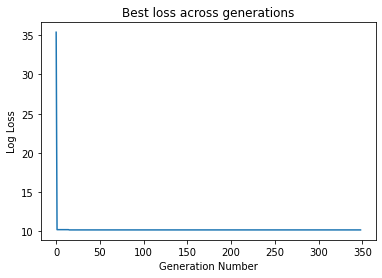

In [59]:
plt.plot(np.log(ALL_TOP_CLASS_LOSS))
plt.title('Best loss across generations')
plt.xlabel('Generation Number')
plt.ylabel('Log Loss')

Text(0.5, 0, 'Generation number')

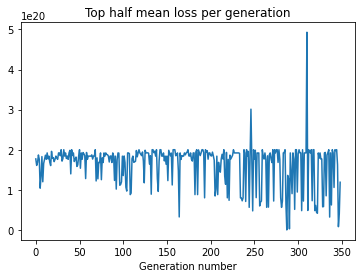

In [60]:
plt.title("Top half mean loss per generation")
plt.plot(ALL_TOP_HALF_LOSS)
plt.xlabel("Generation number")

In [61]:
print(f"The RMSE overall for our best class found is {BEST_RMA_CLASS.rmse}")

The RMSE overall for our best class found is 9000.0


In [62]:
print(f"The  loss for the best class found is {BEST_RMA_CLASS.loss}")

The  loss for the best class found is 26100.0


### Which numbers does it do well on

In [63]:
from collections import defaultdict

In [64]:
[BEST_RMA_CLASS.get_prediction_from_architecture(x_train[i]) for i in range(20)]

[6.104720744612502,
 5.8878573702520995,
 900.0,
 -1.1235582092889473e+307,
 6.069468563597114,
 -1.1235582092889473e+307,
 900.0,
 5.202174304687594,
 5.819290704780645,
 6.079268420173738,
 6.403445716844438,
 7.902474577606625,
 900.0,
 6.671133664899598,
 5.9805986298457,
 900.0,
 6.734782684882848,
 900.0,
 5.622058270270067,
 6.292435093379289]

In [65]:
BEST_RMA_CLASS.model_architecture


array(['cos', 'mf_discrete_avg', 'mf_convolve', 'mf_max_pool', 'abs',
       'tan', 'tan', 'mf_linear_transform', 'mf_convolve',
       'mf_pos_step_function', 'abs', 'log', 'mf_max_pool'], dtype='<U20')

In [66]:
n_correct = defaultdict(list)
n_correct_int = 0
N_PREDICTIONS = 250
# change to x test
for pred, actual in zip([BEST_RMA_CLASS.get_prediction_from_architecture(x_test[i]) for i in range(N_PREDICTIONS)], 
                        y_test[:N_PREDICTIONS]):
    pred = int(pred)
    if pred == actual:
        n_correct[actual].append(1)
        n_correct_int+=1
    else:
        n_correct[actual].append(0)

In [67]:
#pct correct
{k:sum(v)/len(v) for k,v in n_correct.items() }

{7: 0.0,
 2: 0.0,
 1: 0.0,
 0: 0.0,
 4: 0.0,
 9: 0.0,
 5: 0.28,
 6: 0.4090909090909091,
 3: 0.0,
 8: 0.0}

In [68]:
print(f"Overall accuracy is {n_correct_int/N_PREDICTIONS}")

Overall accuracy is 0.064


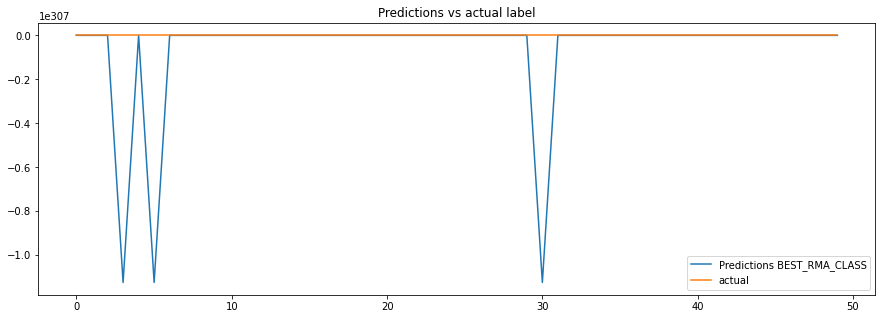

In [69]:
# predictions
N_PREDICTIONS = 30
plt.figure(figsize=(15,5))
plt.title('Predictions vs actual label')
# plt.plot([best_rma_class.get_prediction_from_architecture(x_train[i]) for i in range(N_PREDICTIONS)], label='Predictions')
plt.plot([BEST_RMA_CLASS.get_prediction_from_architecture(x_train[i]) for i in range(50)], label='Predictions BEST_RMA_CLASS')
plt.plot(y_train[:50], label='actual')
plt.legend()

Text(0.5, 0, 'generation')

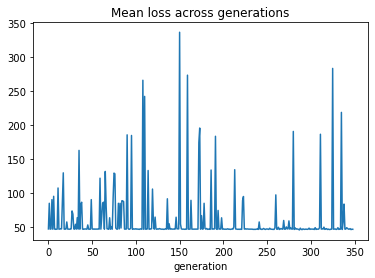

In [70]:
plt.title('Mean loss across generations')
plt.plot(np.log([np.mean(FINAL_GENERATION_LOSS[i]) for i in range(len(FINAL_GENERATION_LOSS))]))
plt.xlabel('generation')

- Most common functions last gen

In [116]:
counts_of_functions = defaultdict(list)

for model in gen_models:
    for m_func in model.model_architecture:
        counts_of_functions[m_func].append(1)
        counts_of_functions[m_func] = [np.sum(counts_of_functions[m_func])]

In [117]:
np.sum(counts_of_functions)

defaultdict(list,
            {'mf_discrete_avg': [75],
             'abs': [60],
             'mf_pow': [61],
             'sin': [10],
             'log': [48],
             'mf_convolve': [20],
             'mf_running_avg': [60],
             'mf_inverse': [37],
             'mf_sigmoid': [41],
             'mf_neg_step_function': [8],
             'mf_sum': [5],
             'mf_max_pool': [4],
             'tan': [57],
             'cos': [75],
             'mf_linear_transform': [11],
             'mf_pos_step_function': [109]})

In [118]:
pd.DataFrame(counts_of_functions).sort_values(by=0,axis=1)

,mf_max_pool,mf_sum,mf_neg_step_function,sin,mf_linear_transform,mf_convolve,mf_inverse,mf_sigmoid,log,tan,abs,mf_running_avg,mf_pow,mf_discrete_avg,cos,mf_pos_step_function
0,4,5,8,10,11,20,37,41,48,57,60,60,61,75,75,109


In [119]:
pd.DataFrame(counts_of_functions).sort_values(by=0,axis=1)/pd.DataFrame(counts_of_functions).sum(axis=1) [0]

,mf_max_pool,mf_sum,mf_neg_step_function,sin,mf_linear_transform,mf_convolve,mf_inverse,mf_sigmoid,log,tan,abs,mf_running_avg,mf_pow,mf_discrete_avg,cos,mf_pos_step_function
0,0.005874,0.007342,0.011747,0.014684,0.016153,0.029369,0.054332,0.060206,0.070485,0.0837,0.088106,0.088106,0.089574,0.110132,0.110132,0.160059


<AxesSubplot:title={'center':'Last generation, pct of functions used'}>

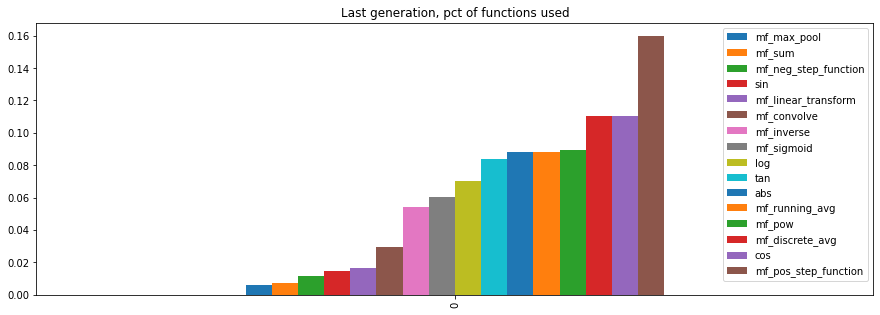

In [120]:

(pd.DataFrame(counts_of_functions).sort_values(by=0,axis=1)/
     pd.DataFrame(counts_of_functions).sort_values(by=0,axis=1).sum(axis=1)[0]
).plot(kind='bar', figsize = (15,5), title = 'Last generation, pct of functions used')


In [121]:
counts_of_functions_first_gen = defaultdict(list)

for model in FIRST_GEN_CLASSES:
    for m_func in model.model_architecture:
        counts_of_functions_first_gen[m_func].append(1)
        counts_of_functions_first_gen[m_func] = [np.sum(counts_of_functions_first_gen[m_func])]

<AxesSubplot:title={'center':'First generation, pct of functions used'}>

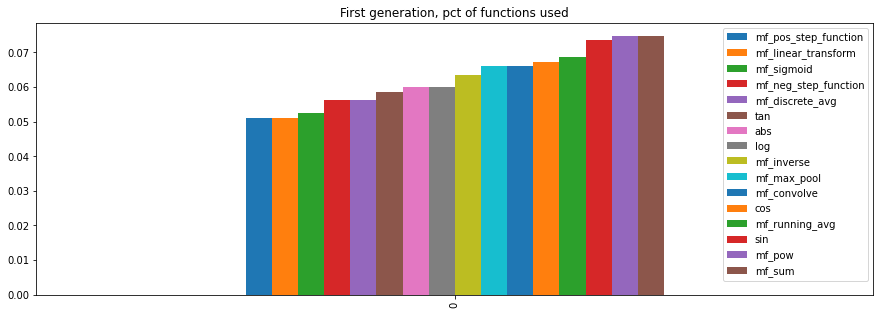

In [122]:

(pd.DataFrame(counts_of_functions_first_gen).sort_values(by=0,axis=1)/
     pd.DataFrame(counts_of_functions_first_gen).sort_values(by=0,axis=1).sum(axis=1)[0]
).plot(kind='bar', figsize = (15,5), title = 'First generation, pct of functions used')

- Most common pixels to process

In [123]:
n_pixels_process_last_gen =  []

for model in gen_models:
    n_pixels_process_last_gen.append(model.n_pixel_to_process)
  

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/model-bias-experiments-1EM9n9A3-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


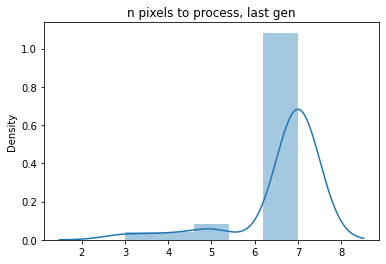

In [124]:
plt.title('n pixels to process, last gen')
sns.distplot(n_pixels_process_last_gen);

In [125]:
n_pixels_process_first_gen =  []

for model in FIRST_GEN_CLASSES:
    n_pixels_process_first_gen.append(model.n_pixel_to_process)
  

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/model-bias-experiments-1EM9n9A3-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


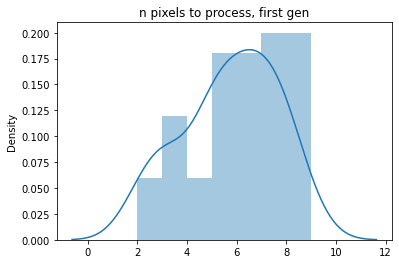

In [110]:
plt.title('n pixels to process, first gen')
sns.distplot(n_pixels_process_first_gen);

- best class model architecture evolve over time

In [111]:
previous_best_model = None


for best_class in BEST_CLASS_ACROSS_GEN:
    print('---------')
    print(best_class.model_architecture)
    if previous_best_model:
        pct_same_architecture = len(set(best_class.model_architecture).intersection(set(previous_best_model.model_architecture))) / len(best_class.model_architecture)
        print(f" For our new best model, the pct of functions that are the same is {pct_same_architecture*100:.4}%")
    previous_best_model = best_class

---------
['mf_sigmoid', 'abs', 'mf_inverse', 'mf_pow', 'mf_max_pool', 'mf_pow', 'mf_sum', 'mf_max_pool', 'abs', 'mf_running_avg', 'mf_pos_step_function', 'cos', 'mf_sum']
---------
['mf_inverse' 'abs' 'mf_running_avg' 'abs' 'mf_sigmoid' 'mf_pow'
 'mf_pos_step_function' 'mf_running_avg' 'abs' 'sin'
 'mf_pos_step_function' 'mf_sigmoid' 'abs' 'mf_discrete_avg' 'mf_sum'
 'mf_sum' 'mf_max_pool' 'mf_discrete_avg' 'mf_linear_transform' 'cos'
 'mf_linear_transform' 'mf_running_avg']
 For our new best model, the pct of functions that are the same is 40.91%
